# Ex 1: Manipulating Spectra Part 1 - `Spectrum`

# Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as physics
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum

## `Spectrum` Class - Introduction

The manipulation of spectral data in this code is done through several specialized classes, all of them equipped with internal methods that make data manipulation and visualization easier than simply using a standard array.

We are broadly interested in two kinds of spectra in this code: spectra produced by various processes at a given redshift, and secondary spectra produced by the injection of a primary particle with some injection energy. 

The `Spectrum` class is designed to contain these kinds of spectra. In its minimal form, it contains an energy abscissa `Spectrum.eng`, as well as an array representing the spectrum in the form of $\frac{dN}{dE}$ (or any other quantity expressed in per unit energy), `Spectrum.dNdE`. It can be initialized as follows:

In [3]:
# Energy abscissa (conventionally defined in eV in this code).
eng = np.array([1, 2, 3, 4, 5])
# dN/dE (conventionally defined in eV^{-1} in this code).
dNdE = np.array([1, 2, 3, 4, 5])
# Initialize Spectrum object at redshift 1+z = 100. 
spec1 = Spectrum(eng, dNdE, rs = 100)

In addition to `Spectrum.eng` and `Spectrum.dNdE`, we passed an additional optional keyword argument `rs`. This sets the redshift associated with the spectrum (always defined as $1+z$ in this code) to be 100, and is stored in the attribute `Spectrum.rs`. 

It may not always make sense to associate a redshift with the spectrum. In this case, we can omit the `rs` keyword, and `Spectrum.rs` will be set to -1. However, this prevents the use of any function that requires the spectrum to have a redshift to have sensible results, e.g. redshifting of the spectrum. As a rule, the redshift should always be set if it is known. 

We can also initialize a `Spectrum` object which is a secondary spectrum, produced by a primary particle undergoing some interaction. In this case, it would be helpful to associate an injection energy with the spectrum. This is done as follows:

In [4]:
# Energy abscissa (conventionally defined in eV in this code).
eng = np.array([1, 2, 3, 4, 5])
# dN/dE (conventionally defined in eV^{-1} in this code).
dNdE = np.array([1, 2, 3, 4, 5])
# Initialize Spectrum object with injection energy = 10 eV. 
spec2 = Spectrum(eng, dNdE, in_eng = 10)

Again, if `Spectrum.in_eng` is not set, its default value is -1. Both `Spectrum.rs` and `Spectrum.in_eng` can be set simultaneously. Again, as a rule, the injection energy of a secondary spectrum should always be set if it is known. 

## Basic Operations

What can we do we `Spectrum` objects? Standard operations like addition or multiplication work as you might expect. Let's perform some basic operations on `spec1` and `spec2` to see what happens. 

In [5]:
spec_add = spec1 + spec2
print('The summed dN/dE is: ', spec_add.dNdE)
spec_sub = spec1 - spec2
print('The subtracted dN/dE is: ', spec_sub.dNdE)
spec_mult = spec1 * spec2
print('The multiplied dN/dE is: ', spec_mult.dNdE)
spec_div = spec1 / spec2
print('The divided dN/dE is: ', spec_div.dNdE)
spec_fac = 30*spec1
print('Multiplying by a factor of 30 gives: ', spec_fac.dNdE)
spec_vec = np.array([3, 3, 3, 3, 3])*spec1
print('Multiplying by an array gives: ', spec_vec.dNdE)

The summed dN/dE is:  [ 2  4  6  8 10]
The subtracted dN/dE is:  [0 0 0 0 0]
The multiplied dN/dE is:  [ 1  4  9 16 25]
The divided dN/dE is:  [ 1.  1.  1.  1.  1.]
Multiplying by a factor of 30 gives:  [ 30  60  90 120 150]
Multiplying by an array gives:  [ 3  6  9 12 15]


Note, however, that because `spec1.rs != spec2.rs`, and `spec1.in_eng != spec2.in_eng`, all the new `Spectrum` objects produced above have *both* of these attributes set to zero, since it cannot decide which parameter value to keep: 

In [6]:
print('The redshift of spec_add is: ', spec_add.rs)
print('The injected energy of spec_add is: ', spec_add.in_eng)

The redshift of spec_add is:  -1
The injected energy of spec_add is:  -1


However, if we set both `spec1` and `spec2` to have the same redshift and the same injection energy, then these operations preserve the redshift and injection energy:

In [7]:
spec1.in_eng = 10
print('The injected energy for spec1 + spec2 is: ', (spec1+spec2).in_eng)
print('The redshift for spec1 + spec2 is: ', (spec1+spec2).rs)
spec2.rs = 100
print('The redshift for spec1 + spec2 is now: ', (spec1+spec2).rs)

The injected energy for spec1 + spec2 is:  10
The redshift for spec1 + spec2 is:  -1
The redshift for spec1 + spec2 is now:  100


## Binning

`Spectrum` should be viewed as a list of bins, with some number of particles in each bin. Throughout the code, the abscissa `Spectrum.eng` is treated as a list of bin *centers*, with the bin boundaries taken to be the midpoint in log of the abscissa. Specifically, the bin boundary between two successive abscissa values $E_1$ and $E_2$ is $\frac{1}{2} ( \log E_1 + \log E_2)$. The first and last bin boundary are chosen so that the first and last abscissa values lie at the center of their respective bins. This means that `Spectrum` must have at least 2 abscissa values. 

## Discretizing an Analytic Spectrum

We will now demonstrate how to use the `Spectrum` class to model the CMB energy spectrum. The number density of CMB photons per unit energy is given by

$$ \frac{dn_{\text{CMB}}}{dE} = \frac{8\pi E^2}{\lambda_c^3 m_e^3} \frac{1}{e^{E/T} - 1} $$

where $\lambda_c$ is the Compton wavelength of the electron, and $T$ is the CMB temperature. The function `physics.CMB_spec` returns this result as a function of $E$ and $T$. To turn this analytic expression into a discrete spectrum stored in a `Spectrum` class, we use the function `spectools.discretize`, which takes as an argument an energy abscissa and the analytic function (which returns $dN/dE$), and returns a discretized version of $dN/dE$. 

In [8]:
T = 1.5 # The temperature in eV of the CMB.

# Define the output energy abscissa. 
eng = 10**((np.arange(120)-90)*(1/10))
# Produces the discretized spectrum. 
discrete_CMB = spectools.discretize(eng, physics.CMB_spec, T)

`discrete_CMB` is now a `Spectrum` object, but with no value set for `discrete_CMB.rs`. We can set it to the correct value of the redshift, with the help of `physics.TCMB`, which takes the redshift as its argument:

In [9]:
discrete_CMB.rs = T/physics.TCMB(1)

We can now plot `discrete_CMB` against the analytic expression for the CMB spectrum, to check that they agree:

[1e-08, 10000.0, 1e-10, 1e+20]

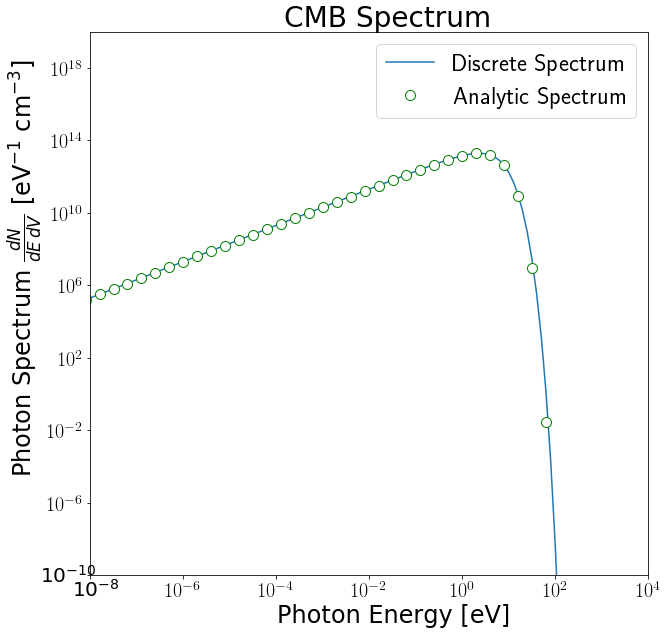

In [10]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

discrete_spec, = plt.plot(
    discrete_CMB.eng, discrete_CMB.dNdE, label='Discrete Spectrum'
)
analytic_spec, = plt.plot(
    eng, physics.CMB_spec(eng, T), 'go', marker='o', markersize='10', 
    markevery=3, markerfacecolor='w', label='Analytic Spectrum'
)

plt.legend(handles=[discrete_spec, analytic_spec], 
           fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('CMB Spectrum', fontsize=28)
plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel(r'Photon Spectrum $\frac{dN}{dE \, dV}$ [eV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([1e-8, 1e4, 1e-10, 1e20])

## `Spectrum` Class - Number and Energy

Let's initialize a new `Spectrum` that is essentially a copy of `discrete_CMB`. 

In [11]:
test_CMB = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, discrete_CMB.rs)

To find the total number of particles stored in this spectrum, we can use the method `self.totN()`, with no arguments. Particle number in a bin is always given by 

$$ N = \frac{dN}{dE} \times E \times \Delta \log E$$

where $\Delta \log E$ is the log bin width of the bin (this can be computed with `spec.spectools.get_log_bin_width`).

This agrees with the actual numerical quadrature over the CMB spectrum given by `physics.CMB_spec` from `eng[0]` to `eng[-1]`, since `spec.spectools.discretize` ensures that the total number of particles *and* total energy in each bin are exactly the value that would be obtained by quadrature of the CMB spectrum. 

In [12]:
print('Number of particles stored in test_CMB: ', test_CMB.totN())
print('Number of particles by quadrature: ', 
      quad(physics.CMB_spec, eng[0], eng[-1], args=T)[0])

Number of particles stored in test_CMB:  1.06996520625e+14
Number of particles by quadrature:  106996520624887.56


`self.totN` can also be used to find the total number of particles in various bins. `self.totN(bound_type='bin')`, for example, returns the total number of particles in each bin. The keyword argument `bound_type` can be used to find the total number of particles between various bin boundaries, which is specified by the keyword argument `bound_arr`. For example, the code below returns the total number of particles in the first two bins. The bin boundaries do not need to be integers. 

In [13]:
print('# of particles in first and second bin: ',
      test_CMB.totN(bound_type='bin', bound_arr=np.array([0,1,2]))
     )

# of particles in first and second bin:  [  2.78182594e-06   7.41174243e-06]


`self.totN` can also return the total number of particles between different energy boundaries, by specifying `bound_type='eng'`: 

In [14]:
print('# of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV: ', 
      test_CMB.totN(bound_type='eng', bound_arr=np.array([0.2, 0.45, 0.6]))
     )

# of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV:  [  1.45086071e+12   1.37229631e+12]


The function `self.toteng()` serves a similar purpose. Energy in a bin is always evaluated as
$$ E = \frac{dN}{dE} \times E^2 \times \Delta \log E $$

In [15]:
def CMB_EdNdE_at_T(eng):
    return eng*physics.CMB_spec(eng, T)

print('Total energy stored in test_CMB: ', test_CMB.toteng())
print('Total energy by quadrature: ', quad(CMB_EdNdE_at_T, eng[0], eng[-1])[0])

Total energy stored in test_CMB:  4.33524976666e+14
Total energy by quadrature:  433524976666076.75


## `Spectrum` Class - Redshifting and Underflow

Photon redshifting is built in to the `Spectrum` class. The function `Spectrum.redshift` redshifts the spectrum as a spectrum of $dN/dE$. Here, we perform a redshift from $1+z$ to $(1+z)/f$. 

In [16]:
# factor to redshift by
f = 10
test_CMB.redshift(test_CMB.rs/f)

The resulting redshifted spectrum conserves total number, with the total energy reduced by half. Here is a plot of the new spectrum, and a comparison of the total number and total density. We divide by an additional factor of $f^3$ to compare per co-moving volume instead. 

Original total number of particles:  1.06996520625e+14
Redshifted total number of particles:  1.06996520625e+14
Ratio:  1.0
**********************************************************
Original total energy:  4.33524976666e+14
Redshifted total energy:  4.33524976666e+13
Ratio:  10.0


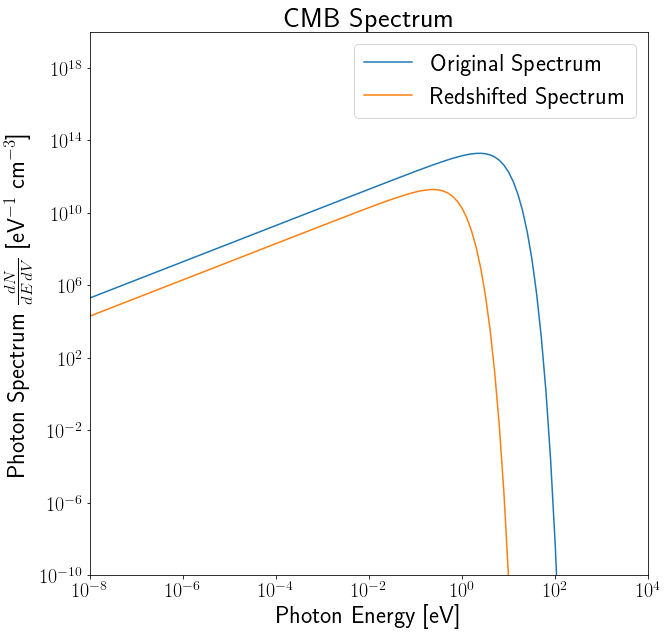

In [17]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

orig_spec, = plt.plot(discrete_CMB.eng, discrete_CMB.dNdE, label='Original Spectrum')
redshifted_spec, = plt.plot(test_CMB.eng, test_CMB.dNdE/f**3, label='Redshifted Spectrum')

plt.legend(handles=[orig_spec, redshifted_spec], fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('CMB Spectrum', fontsize=28)
plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel(r'Photon Spectrum $\frac{dN}{dE\, dV}$ [eV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([1e-8, 1e4, 1e-10, 1e20])

print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', test_CMB.totN())
print('Ratio: ', discrete_CMB.totN()/test_CMB.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', test_CMB.toteng())
print('Ratio: ', discrete_CMB.toteng()/test_CMB.toteng())


Note that the energy abscissa doesn't change after redshifting. Number and energy are both conserved by assigning particles that redshift below the energy abscissa into an underflow. Underflow number and energy are included in `self.totN()` and `self.toteng()`. 

In [18]:
print('Number of particles in underflow: ',test_CMB.underflow['N'])
print('Energy in underflow: ', test_CMB.underflow['eng'])

Number of particles in underflow:  0.000789656406817
Energy in underflow:  4.69216107735e-13


## `Spectrum` - Rebinning and Shifting

The energy abscissa of a `Spectrum` object can be adjusted, but the user should not simply change `Spectrum.eng`, because the total number will not be conserved due to this change.

If every photon in a bin, with energies $E_1, \cdots, E_n$, loses some amount of energy, and now has new energies $E_1', \cdots, E_n'$, the abscissa can be shifted down to the new abscissa, while conserving number, using the function `Spectrum.shift_eng`. 

A closely related function is `Spectrum.rebin`. This re-distributes the spectrum into a new abscissa, while conserving number *and* energy. The new abscissa must have a maximum energy higher than the old abscissa, so that there is no overflow. 

As an example, we will perform redshifting explicitly using these two functions from $1+z$ to $(1+z)/f$. Photons at an energy $E_n$ are shifted to energy $E_n/f$ using `Spectrum.shift_eng`. Then, we rebin the resulting spectrum back into the original abscissa to get the redshifted spectrum using `Spectrum.rebin`. The result is identical to calling the `Spectrum.redshift` function.

Original total number of particles:  1.06996520625e+14
Redshifted total number of particles:  1.06996520625e+14
Ratio:  1.0
**********************************************************
Original total energy:  4.33524976666e+14
Redshifted total energy:  4.33524976666e+13
Ratio:  10.0


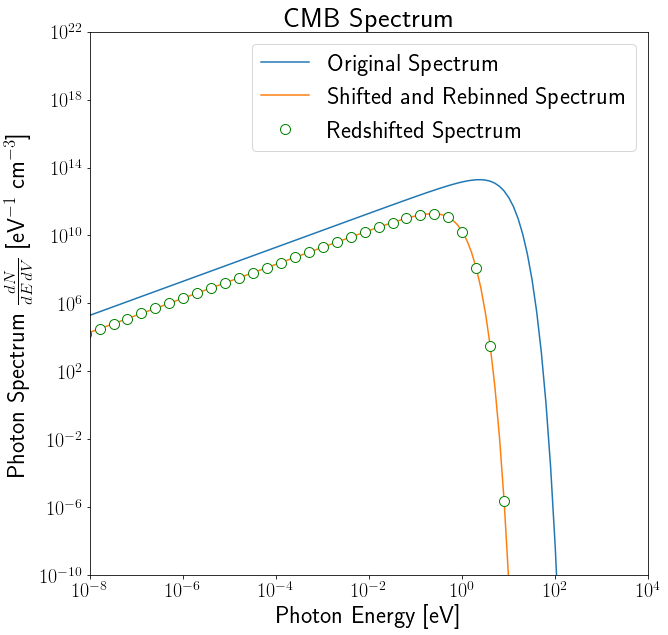

In [19]:
test_CMB_2 = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, discrete_CMB.rs)
test_CMB_2.shift_eng(discrete_CMB.eng/f)
test_CMB_2.rebin(discrete_CMB.eng)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

orig_spec, = plt.plot(discrete_CMB.eng, 
                      discrete_CMB.dNdE, 
                      label='Original Spectrum')
rebinned_spec, = plt.plot(test_CMB_2.eng, 
                          test_CMB_2.dNdE/f**3, 
                          label='Shifted and Rebinned Spectrum')
redshifted_spec, = plt.plot(test_CMB.eng, 
                            test_CMB.dNdE/f**3,'go',
                            marker='o', markersize='10', 
                            markevery=3, markerfacecolor='w', 
                            label='Redshifted Spectrum')


plt.legend(handles=[orig_spec, rebinned_spec, redshifted_spec], 
           fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('CMB Spectrum', fontsize=28)
plt.xlabel('Photon Energy [eV]',fontsize=24)
plt.ylabel(r'Photon Spectrum $\frac{dN}{dE\, dV}$ [eV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([1e-8, 1e4, 1e-10, 1e22])

print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', test_CMB_2.totN())
print('Ratio: ', discrete_CMB.totN()/test_CMB_2.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', test_CMB_2.toteng())
print('Ratio: ', discrete_CMB.toteng()/test_CMB_2.toteng())
